# 混合ガウス分布

<!-- p(x)=Σk:1_K[π_k*(x|μ_k,Σ_k)

潜在変数zを導入
zはK次元でK個要素のうちどれか一つだけ1である(one-hot-vector)
zはデータxがどのガウス分布から生成されたかを表し、下のような分布になります

p(z_k=1)=π_k
p(x|z_k=1)=π_k*N(x|μ_k,Σ_k)

p(x)=Σz[p(x,z)]=Σz[p(z)p(x|z)]=ΣK[π_k*N(x|μ_k,Σ_k)] -->

```math
\begin{matrix}
\phi &=& \set{\phi_{1}, \phi_{2}, \cdots, \phi_{K}} \\
\mu &=& \set{\mu_{1}, \mu_{2}, \cdots, \phi_{K}} \\
\sum &=& \set{\sum_{1}, \sum_{2}, \cdots, \sum_{K}} 
\end{matrix}
```

```math
\begin{matrix}
P(\boldsymbol{x}; \boldsymbol{\theta}) &=& \sum_{j=1}^{K}P(\boldsymbol{x}, z=j; \boldsymbol{\theta}) \\
&=& \sum_{j=1}^{K}P(z=j; \boldsymbol{\theta})P(\boldsymbol{x}|z=j;\boldsymbol{\theta}) \\
&=& \sum_{j=1}^{K}\phi_{j}P(\boldsymbol{x}|z=j;\boldsymbol{\theta})
\end{matrix}
```

```math
D = \set{ \boldsymbol{x}^{1}, \boldsymbol{x}^{2}, \cdots, \boldsymbol{x}^{N} }
```

### 混合ガウス分布の対数尤度
```math
\begin{matrix}
\frac{1}{N}\sum_{n=1}^{N}logP(\boldsymbol{x}^{n}; \theta) &=& \frac{1}{N}\sum_{n=1}^{N}log\sum_{j=1}^{K}\phi_{j}N(\boldsymbol{x}^{n}; \boldsymbol{\mu}^{j}, \sum_{j})
\end{matrix}
```

### 混合ガウス分布のためのEMアルゴリズム

#### Eステップ
+ 各n,kに対して次の値を計算する.
```math
\begin{matrix}
q^{n}(k) &=& \frac{\phi_{k}N(\boldsymbol{x}^{n}; \boldsymbol{\mu}_{k}, \sum_{k})}{\sum_{j=1}^{K}phi_{k}N(\boldsymbol{x}^{n}; \boldsymbol{\mu}_{k}, \sum_{k})}
\end{matrix}
```

#### Mステップ
```math
\begin{matrix}
\phi_{k} &=& \frac{\sum_{n=1}^{N}q^{n}(k)}{-\beta} \\
-\beta &=& N \\
\phi_{k} &=& \frac{\sum_{n=1}^{N}q^{n}(k)}{N} \\
\boldsymbol{\mu_{k}} &=& \frac{\sum_{n=1}^{N}q^{n}(k)\boldsymbol{x}^{n}}{\sum_{n=1}^{N}q^{n}(k)} \\
\boldsymbol{\sum_{k}} &=& \frac{\sum_{n=1}^{N}q^{n}(k)(\boldsymbol{x}^{n} - \boldsymbol{\mu}_{k})(\boldsymbol{x}^{n} - \boldsymbol{\mu}_{k})^T}{\sum_{n=1}^{N}q^{n}(k)}
\end{matrix}
```

#### 終了判定
```math
\frac{1}{N}\sum_{n=1}^{N}log\sum_{j=1}^{K}\phi_{j}N(\boldsymbol{x}^{n}; \boldsymbol{\mu}^{j}, \sum_{j})
```

#### EMアルゴリズムによる混合ガウス分布の推定

In [23]:
# データセット
import os
import numpy as np
from pathlib import Path



# path = os.path.join(os.path.dirname(__file__), 'data', 'old_faithful.txt')
path = os.path.join(Path().resolve(), 'data', 'old_faithful.txt')
xs = np.loadtxt(path)
print(xs.shape)

# パラメータ (初期値)
phis = np.array([0.5,0.5])
mus = np.array([[0.0,50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

K = len(phis) # 潜在変数は2個 z_1, z_2
N = len(xs) # 272 データ点数
MAX_ITERS = 100
THRESHOLD = 1e-4

(272, 2)


In [24]:
# 多次元ガウス分布
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

In [25]:
# 混合ガウス分布
def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

In [26]:
# 平均尤度
def likelihood(xs, phis, mus, covs):
    esp = 1e-6 # log(0)を防ぐための微小値
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + esp)
    return L / N

EMアルゴリズムによる潜在変数 $z_k$ を持つモデルの最尤推定

In [27]:
# 反復処理
current_likelihood = likelihood(xs, phis, mus, covs)
for iter in range(MAX_ITERS):
    # Eステップ
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] /= gmm(x, phis, mus, covs) # 潜在変数zの事後分布: 負担率 q(z_1 | x^n), q(z_2 | x^n)
    
    # Mステップ
    qs_sum = qs.sum(axis=0) # データ方向 (k_1, k_2)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N

        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]

        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k] # (272, )
            z = z[:, np.newaxis] # (272, 1)
            c += qs[n, k] * z @ z.T # スカラ
        covs[k] = c / qs_sum[k]

        # 終了判定
        print(f"{current_likelihood:.3f}") # 平均対数尤度
        next_likelihood = likelihood(xs, phis, mus, covs)
        diff = np.abs(next_likelihood - current_likelihood)
        if diff < THRESHOLD:
            break
        current_likelihood = next_likelihood



-12.797
-6.613
-4.415
-4.420
-4.357
-4.342
-4.302
-4.276
-4.245
-4.225
-4.200
-4.183
-4.164
-4.162
-4.156
-4.156
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155
-4.155


### 最尤推定した混合ガウス分布

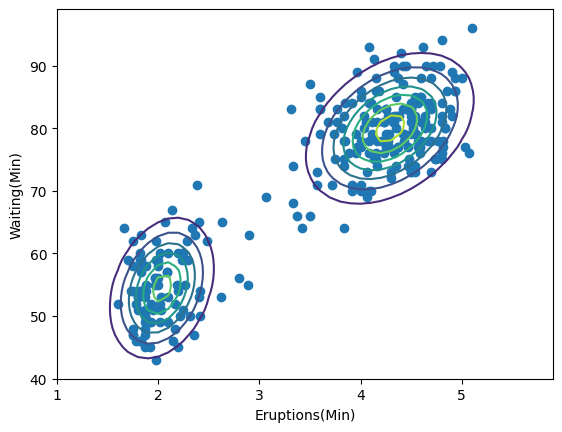

In [30]:
from matplotlib import pyplot as plt
%matplotlib inline

# visualize
def plot_contour(w, mus, covs):
    x = np.arange(1, 6, 0.1)
    y = np.arange(40, 100, 1)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])

            for k in range(len(mus)):
                mu, cov = mus[k], covs[k]
                Z[i, j] += w[k] * multivariate_normal(x, mu, cov)
    plt.contour(X, Y, Z)

plt.scatter(xs[:,0], xs[:,1])
plot_contour(phis, mus, covs)
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

データ生成

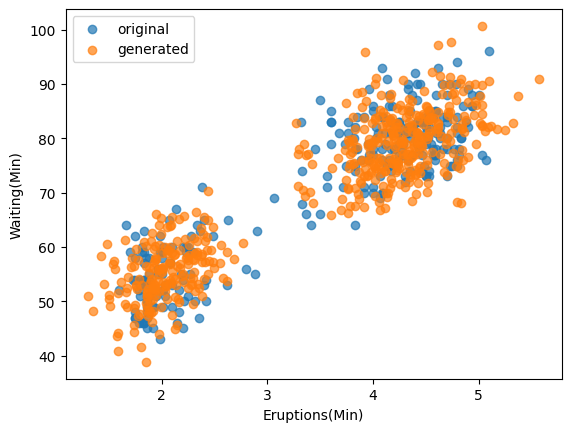

In [32]:
# データ生成

# learned parameters
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00 ]]])
phis = np.array([0.35, 0.65])

original_xs = np.loadtxt(path)

'''生成モデル'''
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(2, p = phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov) # 確率分布からのサンプリング (ここが生成!)

# visualize
plt.scatter(original_xs[:,0], original_xs[:,1], alpha=0.7, label='original')
plt.scatter(new_xs[:,0], new_xs[:,1], alpha=0.7, label='generated')
plt.legend()
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

r: [4.37587211e-12 8.91773001e-12 9.63662761e-12 3.83441519e-12
 7.91725038e-12 5.28894920e-12 5.68044561e-12 9.25596638e-12]

sum(r): 5.4907256485937416e-11

prob: [0.0796957  0.16241442 0.17550736 0.0698344  0.14419315 0.09632514
 0.10345528 0.16857456]

sum(prob): 1.0

log_prob: [-2.52953968 -1.81760409 -1.7400743  -2.66162859 -1.93660154 -2.34002593
 -2.26861583 -1.78037716]

log(r): [-26.15491528 -25.44297969 -25.3654499  -26.28700419 -25.56197714
 -25.96540153 -25.89399143 -25.40575276]
<class 'numpy.ndarray'>
(8,)

minC: -26.28700418602111
type(minC): <class 'numpy.float64'>
c - minC: [0.13208891 0.8440245  0.92155428 0.         0.72502704 0.32160266
 0.39301275 0.88125143]
logsumexp(log_r): -23.625375599718865
<class 'numpy.float64'>
()

log[r/sum(r)]: [-2.52953968 -1.81760409 -1.7400743  -2.66162859 -1.93660154 -2.34002593
 -2.26861583 -1.78037716]

exp( log[r/sum(r)] ): [0.0796957  0.16241442 0.17550736 0.0698344  0.14419315 0.09632514
 0.10345528 0.16857456]

sum { exp( log[

gaussian_likelihood: 0.14281024486839525
gaussian_loglikelihood: -1.9462384888741657
exp(gaussian_loglikelihood): 0.14281024486839525


mean: [[0.5488135  0.71518937]
 [0.60276338 0.54488318]]
cov: [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
pi: [0.4236548  0.64589411]
gauss_dist: 0.14281024486839525
log_likelihood: -850.9406988846891


# メインプログラム

turn:0, logLike:nan
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: 

/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/inoueshinichi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


<class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'nu

type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC)

minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan


minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan
type(minC): <class 'numpy.float64'>
c - minC: [nan nan]
minC: nan


KeyboardInterrupt: 